### Install the `torchmetrics` library for evaluation.

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics.classification import Accuracy
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_CLASSES = 10

In [5]:
def load_data(T, batch_size):
  train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=T)
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=T)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [6]:
def plot_results(train_losses, test_losses, test_accuracies):
  """
  Plot the train and test losses and accuracy values over a number of epochs.
  """
  fig, ax = plt.subplots(1, 2, figsize=(9, 3))

  ax[0].plot(train_losses, label='Train Loss')
  ax[0].plot(test_losses, label='Test Loss', color='red')
  ax[0].legend()
  ax[1].plot([value for value in test_accuracies], label='Test Accuracy', color='green')

  ax[0].set_title('Train / Test Loss')
  ax[1].set_title('Test Accuracy')

  plt.show()

# Q1. Complete the following implementations:
- `train_epoch`
- `eval_model`
- `run_experiment`
- `SimpleCNN`
- `ResNet50Transfer`
- `VGGTransfer`


In the following functions, you are training and evaluating the model for just one epoch (One full pass through the dataset). Complete the `train_epoch` and `eval_model` functions.

In [7]:
def train_epoch(model, train_loader, optimizer, criterion, device):
  """
  Train the model for one epoch.

  args:
    model: torch.nn.Module, the model to train
    train_loader: torch.utils.data.DataLoader, the dataloader for the training set
    optimizer: torch.optim.Optimizer, the optimizer to use
    criterion: torch.nn.Module, the loss function to use
    device: torch.device

  returns:
    train_loss: float, the average loss over the training set for this epoch
  """
  running_loss = 0.0
  total_batches = len(train_loader) # Total batches of samples in training set

  # set the model to training e.g. enable dropouts
  model.train(mode=True)

  # Iterate through the batch of samples in the train set
  for inputs, labels in tqdm(train_loader):
    # zero the previously calculated gradients
    optimizer.zero_grad()

    # make predictions
    inputs,labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)

    # calculate the gradient of the loss
    loss.backward()

    # adjust the model parameters based on the gradient
    optimizer.step()

    # keep track of the loss
    running_loss += loss.item()

  # return the average of the loss over all of the batches
  return running_loss / total_batches

def eval_model(model, test_loader, criterion, acc, device):

  """
  Evaluate the model on the test set.

  args:
    model: torch.nn.Module, the model to evaluate
    test_loader: torch.utils.data.DataLoader, the dataloader for the test set
    criterion: torch.nn.Module, the loss function to use
    acc: torchmetrics.Accuracy, the accuracy metric object
    device: torch.device

  returns:
    test_loss: float, the average loss over the test set
    test_acc: float, the accuracy over the test set
  """

  running_loss = 0.0
  total_batches = len(test_loader) # Total batches of samples in testing set
  # set the model to eval mode e.g. disable dropouts
  model.eval()
  # reset the calculated accuracy object
  acc.reset()
  acc

  # make sure the following does not affect the gradient calculation
  with torch.no_grad():
    # Iterate through the batch of samples in the test set
    for inputs, labels in tqdm(test_loader, desc="Testing Batch Samples"):
      # make predictions
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      # calculate the loss
      loss = criterion(outputs, labels)
      # keep track of the loss
      running_loss += loss.item()
      # update the overall accuracy by including the accuracy of this batch
      acc.update(outputs, labels)

  # return:
    # the average loss over the test set
    # the accuracy over the test set
  return running_loss / total_batches, acc.compute().item()

In the following function you will use the previous function to train the model over a number of epochs. Complete the `run_experiment` function.

In [8]:
def run_experiment(model, train_loader, test_loader, optimizer, criterion, device, epochs=10):
  """
  Run the experiment for a given number of epochs.

  args:
    model: torch.nn.Module, the model to train
    train_loader: torch.utils.data.DataLoader, the dataloader for the training set
    test_loader: torch.utils.data.DataLoader, the dataloader for the test set
    optimizer: torch.optim.Optimizer, the optimizer to use
    criterion: torch.nn.Module, the loss function to use
    device: torch.device
    epochs: int, the number of epochs to train for

  returns:
    train_losses: list of floats, the train loss for each epoch
    test_losses: list of floats, the test loss for each epoch
    accuracies: list of floats, the test accuracy for each epoch
  """
  train_losses = []
  test_losses = []
  accuracies = []

  acc = Accuracy('multiclass', num_classes=NUM_CLASSES).to(device) # Initialize the accuracy object

  # Interate through the number of epochs
  for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs}: ")
    # pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    # Train the model (using the `train_epoch` function)
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    # Keep track of the training loss for this epoch
    train_losses.append(train_loss)

    # Evaluate the model (using the `eval_model` function)
    test_loss, test_acc = eval_model(model, test_loader, criterion, acc, device)
    # Keep track of the testing loss and the testing accuracy for this epoch
    test_losses.append(test_loss)
    accuracies.append(test_acc)

    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

  print("Finished training.")

  # return:
    # train_losses: list of floats, the train loss for each epoch
    # test_losses: list of floats, the test loss for each epoch
    # accuracies: list of floats, the test accuracy for each epoch
  return train_losses, test_losses, accuracies

In [9]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()


    # Conv2d (# of input channels ('64' --> 128) so 64 in this case
    #         # of output channels (64 --> '128'), so 128 in this case
    #         kernel size (3x3, so 3),
    #         1 pixel border around input to preserve 32x32 img otherwise it becomes 30x30

    # ReLU
    # Allows non-linearity in network
    # Mitigates the vanishing gradient

    # Maxpooling2d
    # Reduces computational cost through downsampling / reducing size of the feature map while maintaining the important features
    # kernel_size=2, so it's a 2x2 sliding window
    # stride=2, so it's the distance that the sliding window moves vertically & horizontally when sampling

    self.model = nn.Sequential(
      # Convolution(3x3 kernel) channels: 3 -> 32
      nn.Conv2d(3, 32, kernel_size=3, padding=1),
      # ReLU
      nn.ReLU(),
      # Max pooling (2x2)
      nn.MaxPool2d(kernel_size=2, stride=2),


      # Convolution(3x3 kernel) channels: 32 -> 64
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      # ReLU
      nn.ReLU(),
      # Max pooling (2x2)
      nn.MaxPool2d(kernel_size=2, stride=2),

      # Convolution(3x3 kernel) channels: 64 -> 128
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      # ReLU
      nn.ReLU(),
      # Max pooling (2x2)
      nn.MaxPool2d(kernel_size=2, stride=2),


      nn.Flatten(),
      # Linear 512 hidden_dim
      nn.Linear(128*4*4, 512),
      # ReLU
      nn.ReLU(),
      # Linear output -> num_classes
      nn.Linear(512, num_classes)
    )

  def forward(self, x):
    return self.model(x)

In [10]:
class ResNet50Transfer(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    # Initialize Resnet 50 with the default weights
    self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

    # Freeze the resnet weights
    self.resnet.requires_grad_(False)

    # replace the last fully connected layers with the following:
    self.resnet.fc = nn.Sequential(
      # Linear 256 hidden_dim
      nn.Linear(self.resnet.fc.in_features, 256),
      # ReLU
      nn.ReLU(),
      # Linear output -> num_classes
      nn.Linear(256, num_classes)
    )

  def forward(self, x):
    return self.resnet(x)

In [19]:
class VGGTransfer(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    # Initialize VGG16 with the default weights
    self.vgg = vgg16(weights=VGG16_Weights.DEFAULT)
    # Freeze the feature weights
    self.vgg.requires_grad_(False)

    # Replace the classifier with the following:
    self.vgg.classifier = nn.Sequential(
      nn.Flatten(),
      # Linear 256 hidden_dim
      nn.Linear(512 * 7 * 7, 256),
      # ReLU
      nn.ReLU(),
      # Linear output -> num_classes
      nn.Linear(256, num_classes)
    )

  def forward(self, x):
    return self.vgg(x)

# Q2. Run the following experiments and report the results.
- Train and evaluate the `SimpleCNN` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis.

In [22]:
T = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, test_loader = load_data(T, BATCH_SIZE)
simple_cnn = SimpleCNN(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(simple_cnn, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

Epoch 0/5: 


Testing Batch Samples: 100%|██████████| 157/157 [00:02<00:00, 62.18it/s]


Train Loss: 1.7001, Test Loss: 1.4442, Test Accuracy: 0.4802
Epoch 1/5: 


Testing Batch Samples: 100%|██████████| 157/157 [00:03<00:00, 50.01it/s]


Train Loss: 1.3813, Test Loss: 1.3130, Test Accuracy: 0.5273
Epoch 2/5: 


Testing Batch Samples: 100%|██████████| 157/157 [00:02<00:00, 60.95it/s]


Train Loss: 1.2667, Test Loss: 1.2189, Test Accuracy: 0.5649
Epoch 3/5: 


Testing Batch Samples: 100%|██████████| 157/157 [00:02<00:00, 61.95it/s]


Train Loss: 1.1808, Test Loss: 1.1351, Test Accuracy: 0.5942
Epoch 4/5: 


Testing Batch Samples: 100%|██████████| 157/157 [00:02<00:00, 62.93it/s]

Train Loss: 1.1058, Test Loss: 1.1154, Test Accuracy: 0.5968
Finished training.


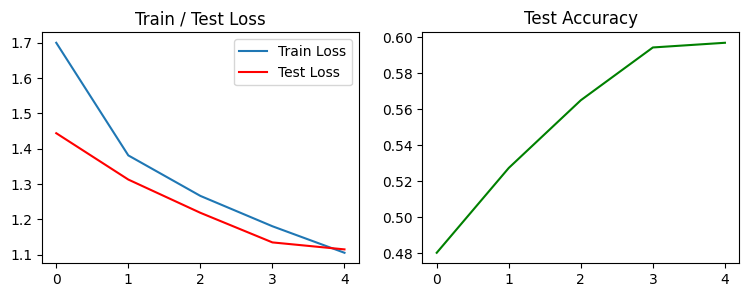

In [23]:
plot_results(train_losses, test_losses, accuracies)

The results of running the SimpleCNN on the CIFAR-10 dataset through 5 epochs show that

1.   The training loss gradually lowers from around 1.70 to 1.11
2.   The test loss gradually decreases from around 1.44 to 1.12
3.   The test accuracy improves from around 0.48 to 0.60

Through observing all of this data we can see that the SimpleCNN model is learning effectively since both the training and test losses start far apart and converge during epoch 3 to 4. Additionally, since the losses are converging versus diverging, it shows that the there is no overfitting.

The accuracy does not seem to be that high because after 5 epochs it seems to be that the accuracy start peaking around 60% which is not reliable when you think about it realistically.

We can conclude that the SimpleCNN is learning well without overfitting, but the accuracy of this model is too low, suggesting that a better model could be used to achieve a higher accuracy.

# Q3. Run the following experiments and report the results.
- Train and evaluate the `ResNet50_Weights` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis. Make comparisons to the previous experiments when appropriate.

In [14]:
T = ResNet50_Weights.DEFAULT.transforms()
train_loader, test_loader = load_data(T, BATCH_SIZE)

resnet_transfer = ResNet50Transfer(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(resnet_transfer.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(resnet_transfer, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


Epoch 0/5: 


Testing Batch Samples: 100%|██████████| 157/157 [00:51<00:00,  3.08it/s]


Train Loss: 1.0475, Test Loss: 0.7087, Test Accuracy: 0.7688
Epoch 1/5: 


Testing Batch Samples: 100%|██████████| 157/157 [00:51<00:00,  3.07it/s]


Train Loss: 0.6698, Test Loss: 0.6181, Test Accuracy: 0.7906
Epoch 2/5: 


Testing Batch Samples: 100%|██████████| 157/157 [00:50<00:00,  3.10it/s]


Train Loss: 0.6015, Test Loss: 0.5842, Test Accuracy: 0.7999
Epoch 3/5: 


Testing Batch Samples: 100%|██████████| 157/157 [00:53<00:00,  2.96it/s]


Train Loss: 0.5640, Test Loss: 0.5682, Test Accuracy: 0.8078
Epoch 4/5: 


Testing Batch Samples: 100%|██████████| 157/157 [00:50<00:00,  3.10it/s]

Train Loss: 0.5395, Test Loss: 0.5568, Test Accuracy: 0.8091
Finished training.


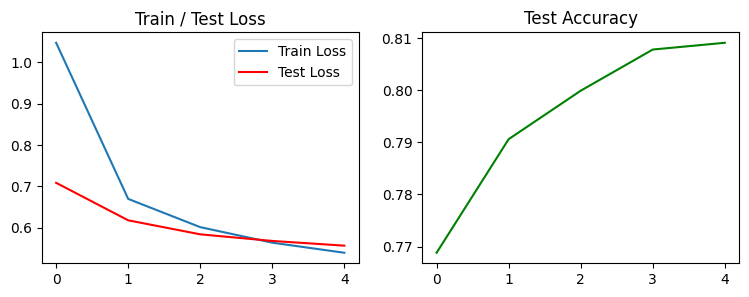

In [15]:
plot_results(train_losses, test_losses, accuracies)

The results of running the ResNet50 Model on the CIFAR-10 dataset through 5 epochs show that

1.   The training loss very quickly drops from over 1.05 to 0.54
2.   The test loss gradually decreases from 0.71 to 0.56
3.   The test accuracy improves from 0.77 to 0.81

Through observing all of this data we can see that the ResNet50 loss already initializes at a lower training and test loss and quickly drops decreases in both training loss and test loss within the first epoch of training. Additionally, we can see that the losses are converging much earlier at epoch 3 instead of 4 which shows quicker initial learning with the model. The final losses for the ResNet50 model are both lower compared to the SimpleCNN model.

The accuracy here ends up initializing at 0.77 which is already quite high and jumps to 0.81 which is a significant improvement compared to the SimpleCNN model.

We can conclude that the ResNet50 model is learning well without overfitting. Compard to the SimpleCNN model it is much more accurate showing an improved ~21% accuracy. Since the losses are converging towards each other around epoch 3, we can see that the model appears to be learning properly with no overfitting.

# Q4. Run the following experiments and report the results.
- Train and evaluate the `VGGTransfer` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis. Make comparisons to the previous experiments when appropriate.

In [20]:
T = VGG16_Weights.DEFAULT.transforms()
train_loader, test_loader = load_data(T, BATCH_SIZE)

vgg_transfer = VGGTransfer(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(vgg_transfer.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(vgg_transfer, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

Epoch 0/5: 


Testing Batch Samples: 100%|██████████| 157/157 [01:14<00:00,  2.12it/s]


Train Loss: 0.4789, Test Loss: 0.3974, Test Accuracy: 0.8627
Epoch 1/5: 


Testing Batch Samples: 100%|██████████| 157/157 [01:14<00:00,  2.11it/s]


Train Loss: 0.2044, Test Loss: 0.4132, Test Accuracy: 0.8639
Epoch 2/5: 


Testing Batch Samples: 100%|██████████| 157/157 [01:15<00:00,  2.09it/s]


Train Loss: 0.1031, Test Loss: 0.4489, Test Accuracy: 0.8612
Epoch 3/5: 


Testing Batch Samples: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s]


Train Loss: 0.0492, Test Loss: 0.4584, Test Accuracy: 0.8649
Epoch 4/5: 


Testing Batch Samples: 100%|██████████| 157/157 [01:15<00:00,  2.08it/s]

Train Loss: 0.0222, Test Loss: 0.4939, Test Accuracy: 0.8653
Finished training.


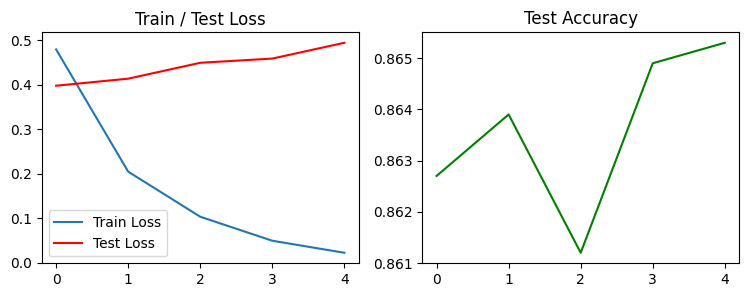

In [21]:
plot_results(train_losses, test_losses, accuracies)

The results of running the VGG Model on the CIFAR-10 dataset through 5 epochs show that

1.   The training loss very quickly drops from over 0.48 to 0.02
2.   The test loss gradually increases from 0.40 to 0.49
3.   The test accuracy stays around 0.86

Through observing all of this data we can see that the VGG loss is clearly diverging against in between the 0th and 1st epoch which is a huge red flag. The divergence shows that there is significant signs of overfitting happening here.

The accuracy here ends up initializing and staying around 0.86. There is a dip at epoch 2 and although this model seems like there's a high accuracy for it, this accuracy does not directly correlate to the training because there is severe overfitting in with the training and testing losses.

We can conclude that the VGG model is learning poorly because there is significant overfitting visible in the losses. This suggests that we might have to change some parameters or structure of the VGG model up in order to eliminate the overfitting or use a different model instead.